Mounted at /content/gdrive
Analyzing original features...
Dataset Shape: (5632, 7)

Feature Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5632 entries, 0 to 5631
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Mode_of_Shipment     5632 non-null   object
 1   Customer_Care_Calls  5632 non-null   int64 
 2   Customer_Rating      5632 non-null   int64 
 3   Cost_of_the_Product  5632 non-null   int64 
 4   Gender               5632 non-null   object
 5   Discount_Offered     5632 non-null   int64 
 6   Reached_on_Time      5632 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 308.1+ KB
None

Numerical Features Statistics:
       Customer_Care_Calls  Customer_Rating  Cost_of_the_Product  \
count          5632.000000      5632.000000          5632.000000   
mean              4.067294         2.978871           211.227983   
std               1.147875         1.415750            

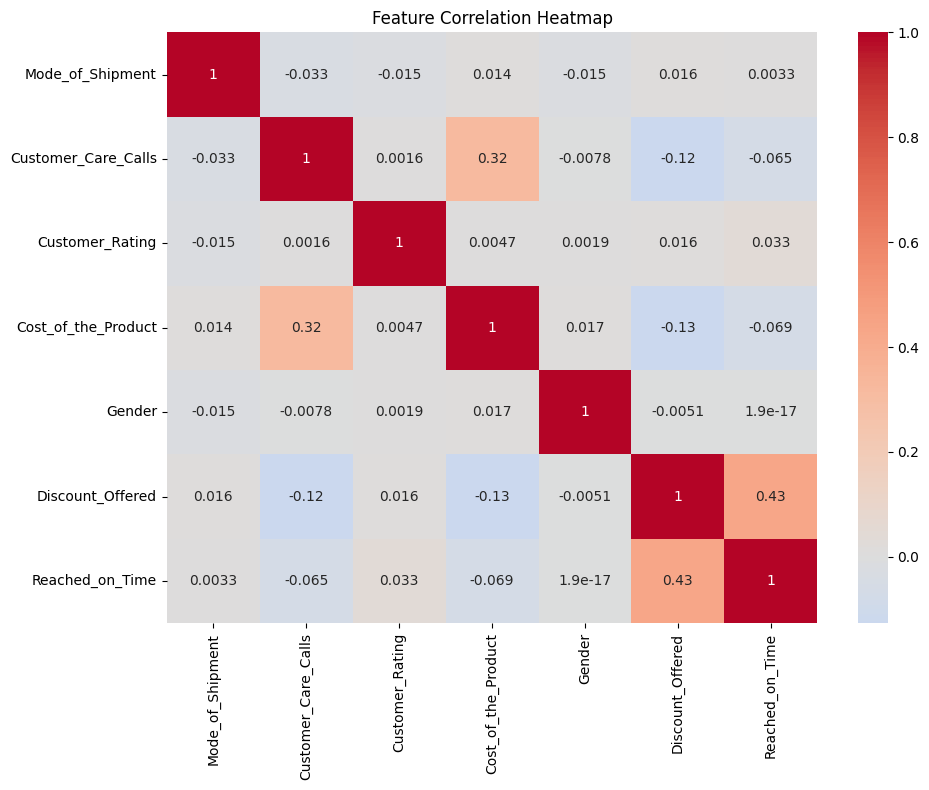


Random Forest Feature Importance:
               feature  importance
2  Cost_of_the_Product    0.585942
4     Discount_Offered    0.244349
1  Customer_Care_Calls    0.095789
0     Mode_of_Shipment    0.034071
3               Gender    0.026806
5      Reached_on_Time    0.013044


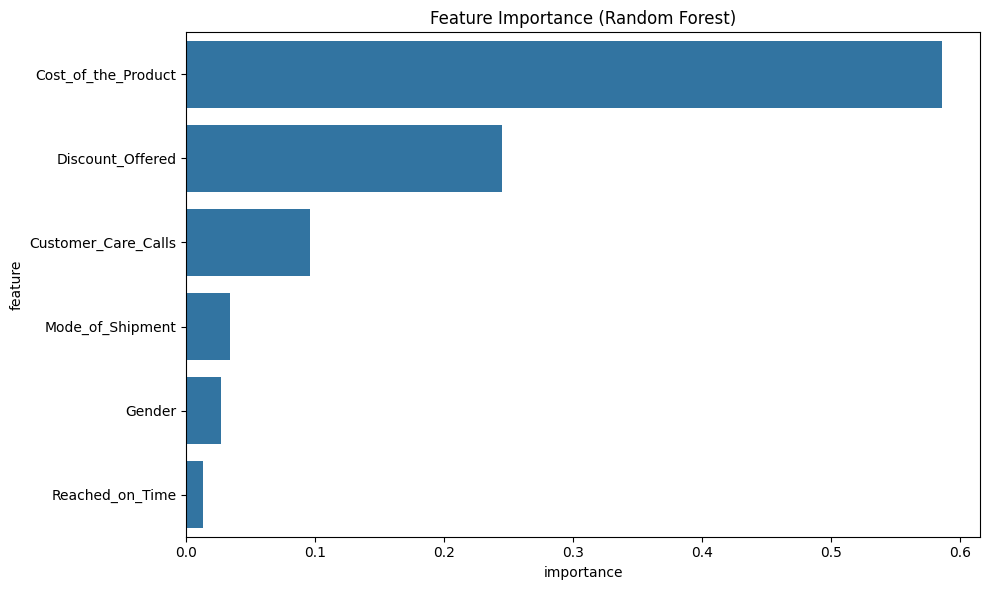


Mutual Information Scores:
Gender                 0.018860
Cost_of_the_Product    0.004593
Mode_of_Shipment       0.001138
Customer_Care_Calls    0.000000
Discount_Offered       0.000000
Reached_on_Time        0.000000
dtype: float64


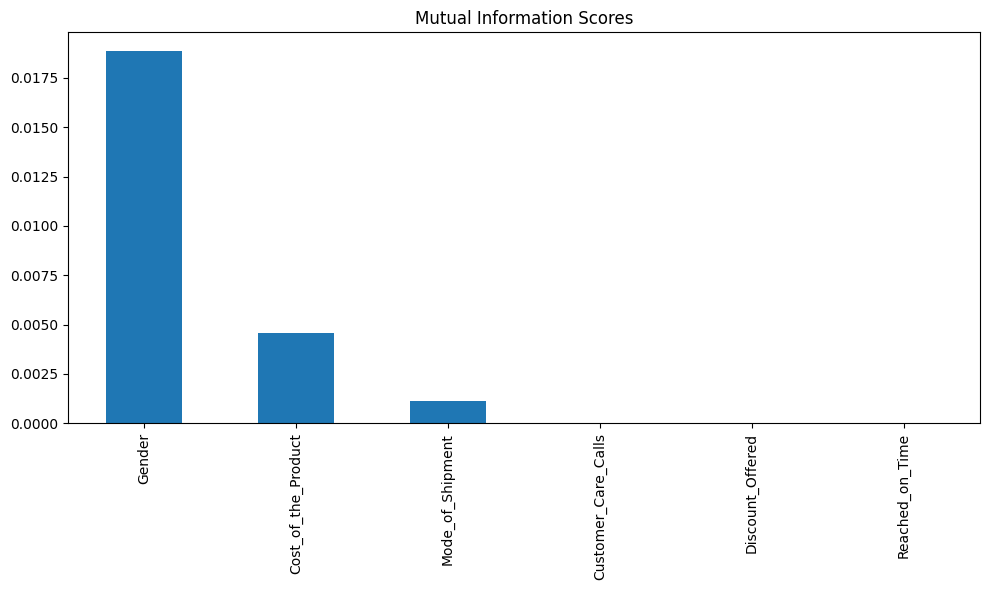


Statistical Analysis:

ANOVA Test Results (Numerical Features):
Customer_Care_Calls: F-statistic = 0.2926, p-value = 0.8829
Cost_of_the_Product: F-statistic = 0.2776, p-value = 0.8926
Discount_Offered: F-statistic = 0.8206, p-value = 0.5118
Reached_on_Time: F-statistic = 2.3569, p-value = 0.0514

Chi-square Test Results (Categorical Features):
Mode_of_Shipment: chi2 = 10.3018, p-value = 0.2445
Gender: chi2 = 0.3228, p-value = 0.9883

Analyzing feature distributions...


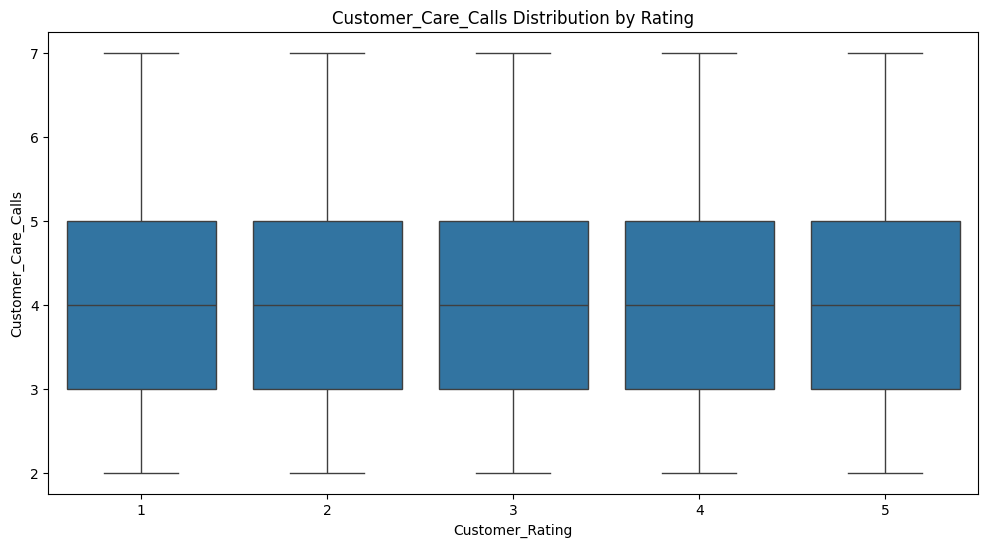

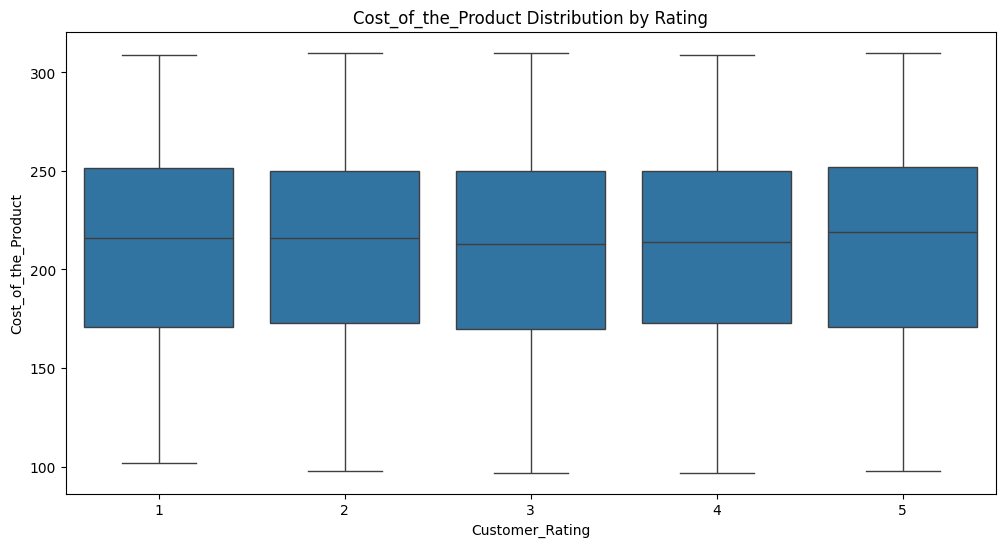

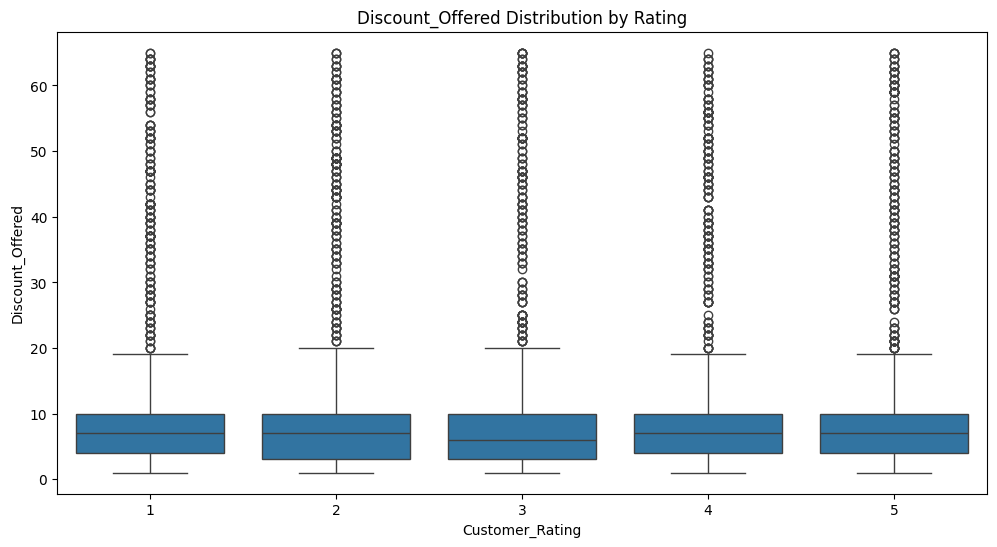

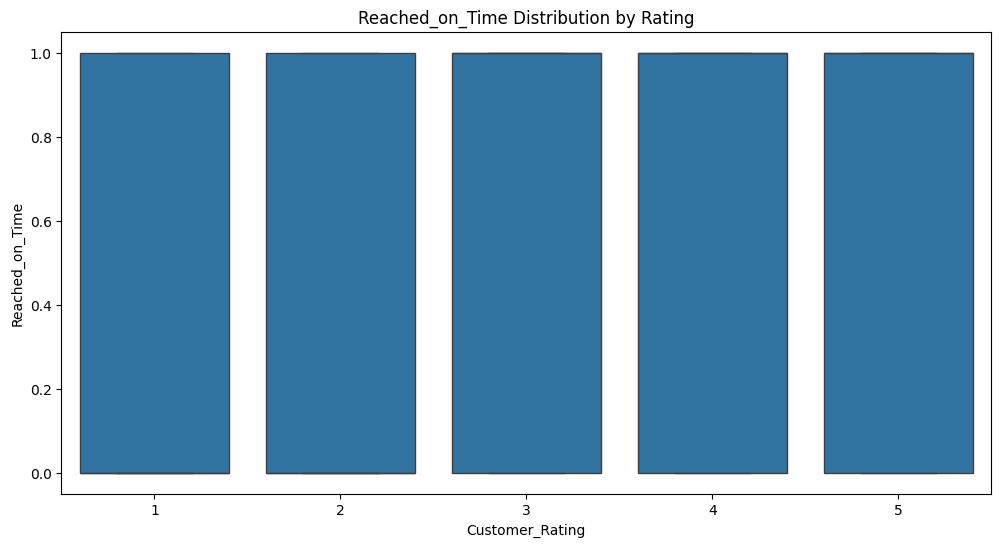

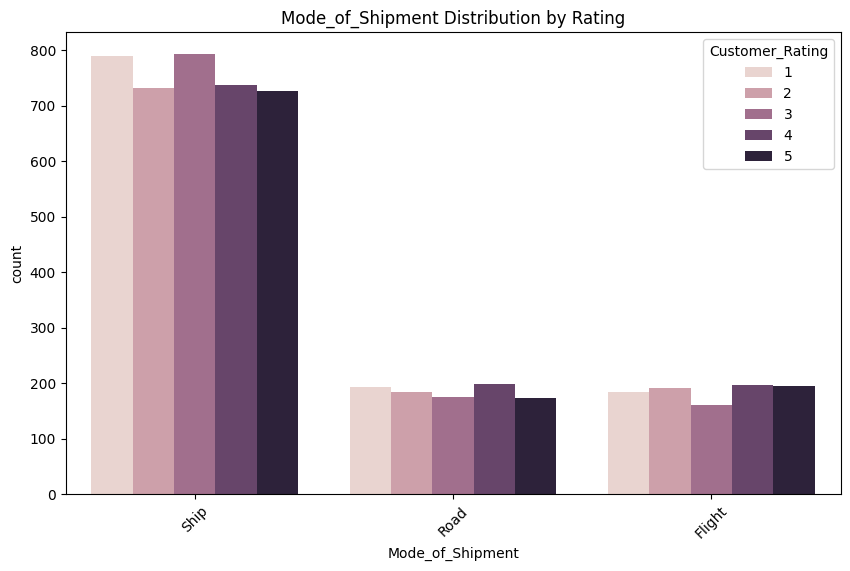

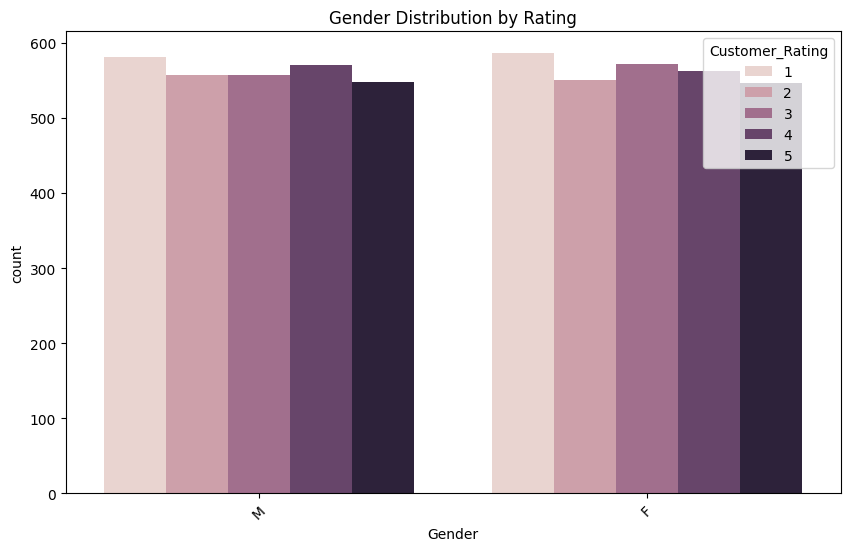


Preparing final datasets...


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_classif, SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/gdrive')
base_path = '/content/gdrive/My Drive/Projects/CustomerSatisfactionLogistics/'

def analyze_features(df):
    """
    Comprehensive feature analysis for customer rating prediction
    """
    print("Dataset Shape:", df.shape)
    print("\nFeature Information:")
    print(df.info())

    # Basic statistics
    print("\nNumerical Features Statistics:")
    print(df.describe())

    # Check for missing values
    print("\nMissing Values:")
    print(df.isnull().sum())

    # Create copy of dataframe for analysis
    df_analysis = df.copy()

    # Encode categorical variables
    le = LabelEncoder()
    categorical_cols = ['Mode_of_Shipment', 'Gender']
    for col in categorical_cols:
        df_analysis[col] = le.fit_transform(df_analysis[col])

    # Correlation analysis
    correlation_matrix = df_analysis.corr()
    target_correlations = correlation_matrix['Customer_Rating'].sort_values(ascending=False)

    print("\nCorrelation with Customer Rating:")
    print(target_correlations)

    # Plot correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Heatmap')
    plt.tight_layout()
    plt.show()

    # Feature importance using Random Forest
    X = df_analysis.drop('Customer_Rating', axis=1)
    y = df_analysis['Customer_Rating']

    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)

    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nRandom Forest Feature Importance:")
    print(feature_importance)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('Feature Importance (Random Forest)')
    plt.tight_layout()
    plt.show()

    # Mutual Information Analysis
    mi_scores = mutual_info_classif(X, y)
    mi_scores = pd.Series(mi_scores, index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)

    print("\nMutual Information Scores:")
    print(mi_scores)

    # Plot mutual information scores
    plt.figure(figsize=(10, 6))
    mi_scores.plot(kind='bar')
    plt.title('Mutual Information Scores')
    plt.tight_layout()
    plt.show()

    # Statistical tests
    print("\nStatistical Analysis:")

    # For numerical features
    numerical_cols = ['Customer_Care_Calls', 'Cost_of_the_Product',
                     'Discount_Offered', 'Reached_on_Time']

    print("\nANOVA Test Results (Numerical Features):")
    for col in numerical_cols:
        f_stat, p_val = stats.f_oneway(*[group[col].values
                                       for name, group in df.groupby('Customer_Rating')])
        print(f"{col}: F-statistic = {f_stat:.4f}, p-value = {p_val:.4f}")

    # For categorical features
    print("\nChi-square Test Results (Categorical Features):")
    for col in categorical_cols:
        chi2_stat, p_val = stats.chi2_contingency(
            pd.crosstab(df[col], df['Customer_Rating'])
        )[:2]
        print(f"{col}: chi2 = {chi2_stat:.4f}, p-value = {p_val:.4f}")

    # Distribution analysis
    print("\nAnalyzing feature distributions...")

    # Plot numerical features distribution by rating
    for col in numerical_cols:
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='Customer_Rating', y=col, data=df)
        plt.title(f'{col} Distribution by Rating')
        plt.show()

    # Plot categorical features distribution
    for col in categorical_cols:
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, x=col, hue='Customer_Rating')
        plt.title(f'{col} Distribution by Rating')
        plt.xticks(rotation=45)
        plt.show()

    return feature_importance, mi_scores, correlation_matrix

def select_features(df, feature_importance, threshold=0.1):
    """
    Select important features based on Random Forest importance scores
    """
    important_features = feature_importance[
        feature_importance['importance'] >= threshold
    ]['feature'].tolist()

    important_features.append('Customer_Rating')  # Add target variable

    return df[important_features]

def create_new_features(df):
    """
    Create new features based on existing ones
    """
    df_new = df.copy()

    # Cost per call ratio
    df_new['Cost_per_Call'] = df_new['Cost_of_the_Product'] / (df_new['Customer_Care_Calls'] + 1)

    # Discount percentage
    df_new['Discount_Percentage'] = (df_new['Discount_Offered'] / df_new['Cost_of_the_Product']) * 100

    # Customer service intensity
    df_new['Service_Intensity'] = df_new['Customer_Care_Calls'] * (1 if df_new['Reached_on_Time'] else 2)

    # Binary features
    df_new['High_Value_Order'] = (df_new['Cost_of_the_Product'] > df_new['Cost_of_the_Product'].median()).astype(int)
    df_new['High_Discount'] = (df_new['Discount_Offered'] > df_new['Discount_Offered'].median()).astype(int)

    # Interaction features
    df_new['Cost_Discount_Interaction'] = df_new['Cost_of_the_Product'] * df_new['Discount_Offered']
    df_new['Service_Delivery_Interaction'] = df_new['Customer_Care_Calls'] * df_new['Reached_on_Time']

    return df_new

def prepare_final_dataset(df, feature_importance):
    """
    Prepare the final dataset with selected and engineered features
    """
    # Create new features
    df_engineered = create_new_features(df)

    # Analyze new dataset
    print("\nAnalyzing dataset with engineered features...")
    new_importance, new_mi_scores, new_correlation = analyze_features(df_engineered)

    # Select final features
    final_df = select_features(df_engineered, new_importance, threshold=0.1)

    print("\nFinal selected features:")
    print(final_df.columns.tolist())

    return final_df

if __name__ == "__main__":
    # Load data
    train_df = pd.read_csv(base_path + 'train_set.csv')
    val_df = pd.read_csv(base_path + 'validation_set.csv')
    test_df = pd.read_csv(base_path + 'test_set.csv')

    # Analyze original features
    print("Analyzing original features...")
    feature_importance, mi_scores, correlation = analyze_features(train_df)

    # Prepare final datasets
    print("\nPreparing final datasets...")
    train_final = prepare_final_dataset(train_df, feature_importance)
    val_final = prepare_final_dataset(val_df, feature_importance)
    test_final = prepare_final_dataset(test_df, feature_importance)

    # Save processed datasets
    train_final.to_csv(base_path + 'train_processed.csv', index=False)
    val_final.to_csv(base_path + 'val_processed.csv', index=False)
    test_final.to_csv(base_path + 'test_processed.csv', index=False)

    print("\nProcessed datasets saved successfully!")